# Outline
1. Unsupervised Learning
2. Parametric clustering
    1. K-means
    2. Gaussian mixture models (GMMs)
    3. Dirichlet Process GMMs
3. Non-parametric clustering and Mean-shift
4. Spectral clustering

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Supervised Learning
- _Supervised learning_ considers input-output pairs $(x,y)$
  - learn a mapping from input to output.
  - _classification_: output $y \in \pm 1$
  - _regression_: output $y \in \mathbb{R}$
- "Supervised" here means that the algorithm is learning the mapping that we want.

# Unsupervised Learning
- Unsupervised learning only considers the input data $x$.
  - There are no output values.
- **Goal:** Try to discover inherent properties in the data.
  - Clustering
  - Dimensionality Reduction
  - Manifold Embedding

# Clustering
- Find clusters of similar items in the data.
- Find a representative item that can represent all items in the cluster.
- **For example:** grouping iris flowers by their measurements.
  - Featuers are sepal width and petal length.
<img width="500px" src="lecture6/cluster.png">

# Dimensionality Reduction
- Transform high-dimensional vectors into low-dimensional vectors.
  - Dimensions in the low-dim data may have semantic meaning.
- **For example:** document analysis
  - high-dim: bag-of-word vectors of documents
  - low-dim: each dimension represents similarity to a topic.
<img src="lecture6/topic.png" width=500px>

# Manifold Embedding
- Project high-dimensional vectors into 2- or 3-dimensional space for visualiation.
  - Points in the low-dim space have similar pair-wise distances as in the high-dim space.
- **For example:** visualize a collection of hand-written digits (images).
<img src="lecture6/isomap.png" width="800px">

# Clustering
- Each data point is a vector $x\in\mathbb{R}^d$.
- Data is set of vectors $\{x_1,\cdots,x_n\}$
- **Goal:** group similar data together.
  - groups are also called clusters.
  - each data point is assigned with a cluster index ($y$)

In [2]:
# define class labels, plot markers, and feature labels
featnames = ("petal length", "sepal width")
axbox = [0, 8, 1.5, 5]
cols = ('r', 'g', 'b')

# make a colormap for viewing classes
mycmap = matplotlib.colors.ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

jet = plt.get_cmap('jet')
rbow = plt.get_cmap('rainbow')

# load iris dataset from scikit-learn
iris = datasets.load_iris()    

# get data
Xiris = iris.data[:,(2,1)]
X = Xiris

km = cluster.KMeans(n_clusters=3, random_state=4487)
km.fit(X)

clusterfig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1])
plt.axis(axbox); plt.grid(True)
plt.title('data')

plt.subplot(1,2,2)
LL = []
for j in range(3):
    inds = (km.labels_ == j)
    LL.append(plt.scatter(X[inds,0], X[inds,1], c=cols[j]))
plt.axis(axbox); plt.grid(True)
plt.title('clustered data')
leg = plt.legend(LL, ('Cluster 1', 'Cluster 2', 'Cluster 3'), fontsize=9)
leg.get_frame().set_facecolor('white')
plt.close()

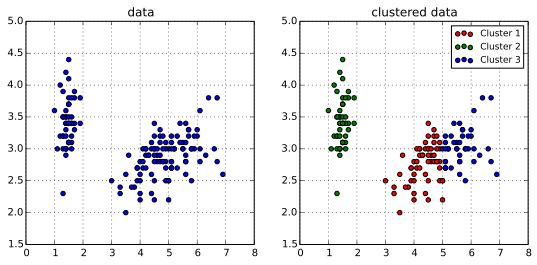

In [3]:
clusterfig

# K-Means Clustering
- **Idea:**
  - each cluster is represented by a _cluster center_.
  - assign each data point to the closest cluster center.

In [4]:
cc = km.cluster_centers_
kmfig = plt.figure()
plt.scatter(X[:,0], X[:,1], c=km.labels_, cmap=rbow)
L = plt.scatter(cc[:,0], cc[:,1], c=range(3), s=250, cmap=rbow, marker='*')
plt.axis(axbox); plt.grid(True)
leg = plt.legend((L,), ('Cluster centers',), fontsize=9)
leg.get_frame().set_facecolor('white')
plt.close()

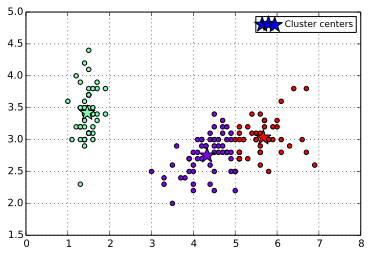

In [5]:
kmfig

# K-means Clustering Objective
- _How to pick the cluster centers?_
  - Pick the cluster centers that minimize the squared distance to all its cluster members.
  - Assume there are $K$ clusters
    - let $c(x_i)$ be the closest cluster center to $x_i$.

$$ \min_{c_1,\cdots,c_K} \sum_{i=1}^n || x_i - c(x_i)||^2$$
  - Solution: mean of the points in the cluster
    - let $C_j$ be the set of points belonging to cluster $j$
    - $c_j = \frac{1}{|C_j|}\sum_{x_i \in C_j} x_i$


# Chicken and Egg Problem
- Cluster assignment of each point depends on the cluster centers.
- Location of cluster center depends on which points are assigned to it.

# K-means Algorithm
- Pick initial cluster centers
- Repeat:
  - 1) assign points $x_i$ to closest cluster center using Euclidean distance.
  - 2) calculate cluster center $c_j$ as average of points assigned to $c_j$.
- This procedure will converge eventually.

In [6]:
# gmm is a gmm/dpgmm
# ax is the axis
# cmap is colormap to use
# cl is the index of components to show [default is None which means all components]
def make_ellipses(gmm, ax, cmap, cl=None):
    if cl == None:
        cl = range(gmm.n_components)
    for n in cl:
        v, w = linalg.eigh(gmm._get_covars()[n])
        u = w[0] / linalg.norm(w[0])
        angle = arctan2(u[1], u[0])
        angle = 180 * angle / pi  # convert to degrees
        s   = sqrt(v)  # stddev
        
        for f in [1,2,3]:
            ss = s*f  
            ell = matplotlib.patches.Ellipse(gmm.means_[n, :2], 2*ss[0], 2*ss[1],
                                      180 + angle, color=cmap(float(n)/max(max(cl),1)))
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.15)
            ax.add_artist(ell)

def plot_clusters(model, X, cmap, showregions=False):
    # model = kmeans, gmm, dpgmm
    # X = points
    # cmap = colormap
    
    name = model.__class__.__name__

    if name != "SpectralClustering":
        Y = model.predict(X)
    else:
        Y = model.labels_
    
    
    if (name == 'KMeans'):
        cc = model.cluster_centers_
        cl = range(model.n_clusters)
    elif (name == 'GMM'):
        cc = model.means_
        cl = range(model.n_components)
    elif (name == 'DPGMM'):
        cl = unique(Y)        # find active clusters
        cc = model.means_[cl] # get means
    elif (name == 'VBGMM'):
        cl = unique(Y)        # find active clusters
        cc = model.means_[cl] # get means
    elif (name == 'MeanShift'):
        cc = model.cluster_centers_
        cl = range(len(cc))
    elif (name == 'SpectralClustering'):
        cc = None
        cl = range(model.n_clusters)
        
    if showregions:    
        # grid of points
        axbox = plt.axis()
        xr = [linspace(axbox[0],axbox[1],200), 
              linspace(axbox[2],axbox[3],200)]
        xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
        allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
        
        # predictions
        Ypred = model.predict(allpts).reshape(xgrid0.shape)
        
        plt.imshow(Ypred, origin='lower', extent=axbox, aspect='auto', 
           vmin=min(cl), vmax=max(cl), alpha=0.2, interpolation='nearest', cmap=cmap)

    # show ellipses
    if ((name == 'GMM') or (name == 'DPGMM') or (name == 'VBGMM')) and (not showregions):  
        make_ellipses(model, plt.gca(), cmap, cl)
    
    # show points
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap)
    
    # show centers
    if cc != None:
        plt.scatter(cc[:,0], cc[:,1], c=cl, s=250, cmap=cmap, marker='*')

    # return number of clusters found
    return (len(cl),)

In [7]:
random.seed(123)
indinit = random.permutation(len(X))[0:3]
ccinit = X[indinit,:]

kmifig = plt.figure(figsize=(10,10))

for i in range(6):
    if i==0:
        tstr = 'initial'
        km = cluster.KMeans(n_clusters=3, max_iter=2, n_init=1, init=ccinit)
        km.fit(X)
        km.cluster_centers_ = ccinit  # force clusters to initial points (hack)        
    else:
        km = cluster.KMeans(n_clusters=3, max_iter=i, n_init=1, init=ccinit)
        km.fit(X)
        cc = km.cluster_centers_
        cl = km.labels_
        tstr = 'iteration ' + str(i)

    plt.subplot(3,2,i+1)
    plot_clusters(km, X, rbow)
    plt.axis(axbox); plt.grid(True)
    plt.title(tstr)
plt.close()


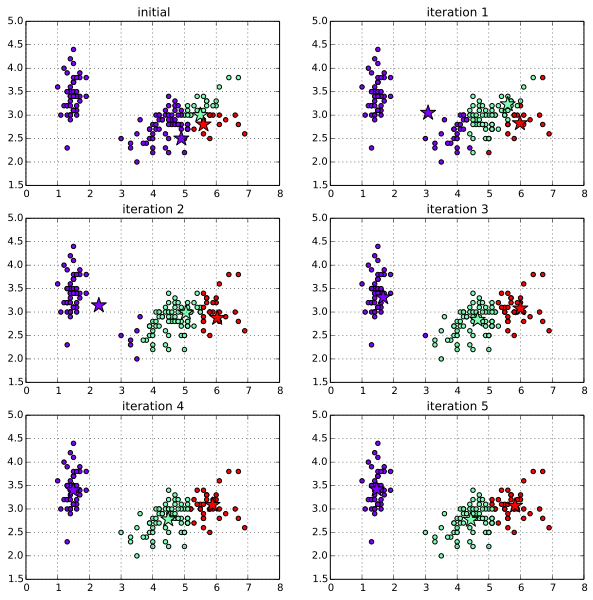

In [8]:
kmifig

# Important Note
- The final result depends on the initial cluster centers!
  - Some bad initializations will yield poor clustering results!
  - (Technically, there are multiple local minimums in the objective function)

In [9]:
random.seed(126)
indinit = random.permutation(len(X))[0:3]
ccinit = X[indinit,:]

kmbadfig = plt.figure(figsize=(10,3))

for i,its in enumerate([0,100]):
    if i==0:
        tstr = 'initial'
        km = cluster.KMeans(n_clusters=3, max_iter=2, n_init=1, init=ccinit)
        km.fit(X)
        km.cluster_centers_ = ccinit  # force clusters to initial points (hack)        
    else:
        km = cluster.KMeans(n_clusters=3, max_iter=its, n_init=1, init=ccinit)
        km.fit(X)
        cc = km.cluster_centers_
        cl = km.labels_
        tstr = 'iteration ' + str(its)

    plt.subplot(1,2,i+1)
    plot_clusters(km, X, rbow)
    plt.axis(axbox); plt.grid(True)
    plt.title(tstr)
plt.close()

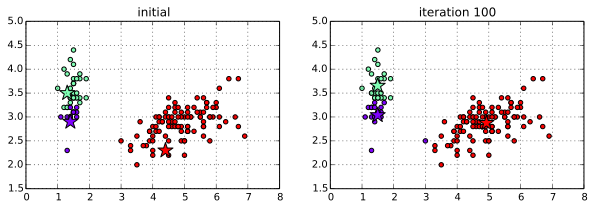

In [10]:
kmbadfig

- **Solution:**
  - Try several times using different initializations.
  - Pick the answer with lowest objective score.
- In scikit-learn,
  - automatically uses multiple random initializations.
  - also uses a smart initialization method called "k-means++"

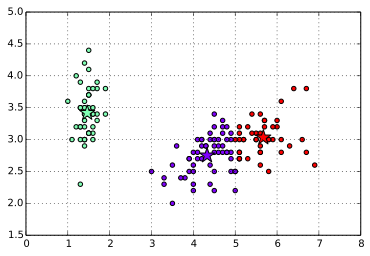

In [11]:
# K-Means with 3 clusters
# (automatically does 10 random initializations)
km = cluster.KMeans(n_clusters=3, random_state=4487)
km.fit(X)

cc = km.cluster_centers_   # the cluster centers
cl = km.labels_            # labels for each X

plt.figure()
plot_clusters(km, X, rbow)
plt.axis(axbox); plt.grid(True)

# For different K
- We need to choose the appropriate K

In [13]:
ksfig = plt.figure(figsize=(10,6))
for i,K in enumerate([2,3,4,5]):
    km = cluster.KMeans(n_clusters=K, random_state=4487)
    km.fit(X)

    plt.subplot(2,2,i+1)
    plot_clusters(km, X, rbow)
    plt.axis(axbox); plt.grid(True)
    plt.title(str(K) + ' clusters')
plt.close()

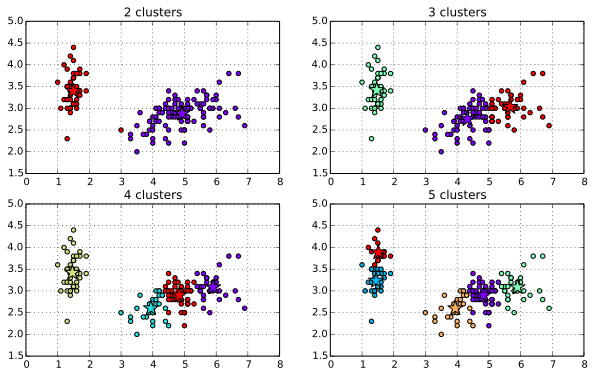

In [14]:
ksfig

- K-means splits the input space into different regions belonging to each cluster

In [16]:
krfig = plt.figure(figsize=(10,6))
for i,K in enumerate([2,3,4,5]):
    km = cluster.KMeans(n_clusters=K, random_state=4487)
    km.fit(X)

    plt.subplot(2,2,i+1)
    plt.axis(axbox); plt.grid(True)
    plot_clusters(km, X, rbow, showregions=True)
plt.close()

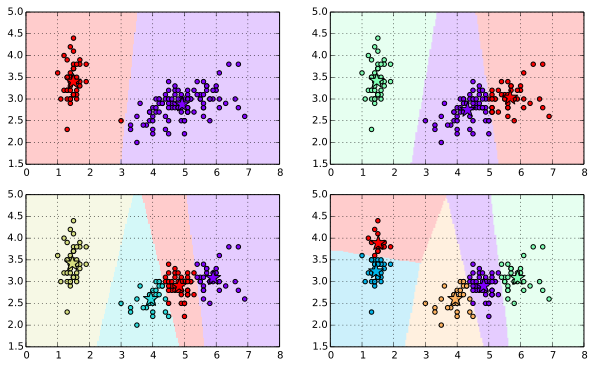

In [17]:
krfig

# Circular clusters
- One problem with K-means is that it assumes that each cluster has a circular shape.
  - based on Euclidean distance to each center
  - Kmeans cannot handle skewed (elliptical) clusters.

In [18]:
random.seed(38)
Xbars,Y = datasets.make_blobs(400,2,[[-15,0],[-5,0],[5,0],[15,0]],cluster_std=0.8)
Xbars[:,0] /=8

X = Xbars

km = cluster.KMeans(n_clusters=4, random_state=4487)
km.fit(X)

efig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c='b')
plt.axis('equal'); plt.grid(True)

plt.subplot(1,2,2)
plot_clusters(km, X, rbow)
plt.axis('equal'); plt.grid(True)
plt.close()

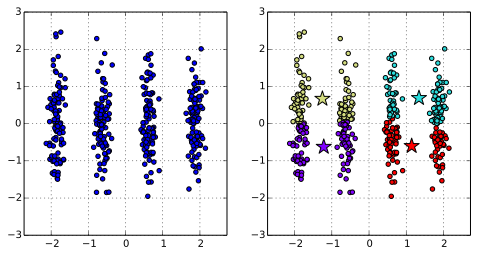

In [19]:
efig

# Gaussian mixture model (GMM)
- A multivariate Gaussian can model a cluster with an elliptical shape.
  - the ellipse shape is controlled by the covariance matrix of the Gaussian
  - the location of the cluster is controlled by the mean.
- Gaussian mixture model is a weighted sum of Gaussians
$$ p(x) = \sum_{j=1}^K \pi_j N(x|\mu_j, \Sigma_j)$$
  - $\mu_j$ is the mean of the j-th Gaussian.
  - $\Sigma_j$ is the covariance matrix of the j-th Gaussian.
  - $\pi_j$ is the weight of the j-th Gaussian.

# 1-D example of GMM

In [20]:
eggmm = plt.figure(figsize=(6,3))

x = linspace(-8,8,100)
px = 0.25*(stats.norm.pdf(x+2)/2 ) + 0.75*(stats.norm.pdf(x-3))

plt.plot(x,px, 'b-')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(True)
plt.close()

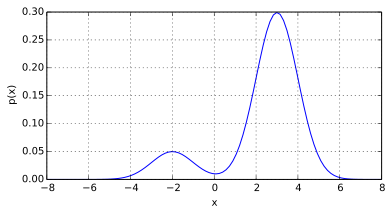

In [21]:
eggmm

# Clustering with GMMs
- Using the data, learn a GMM using maximum likelihood estimation:
  $$\max_{\pi,\mu,\Sigma} \sum_{i=1}^N \log \sum_{j=1}^K \pi_j N(x|\mu_j, \Sigma_j)$$
- Results in an algorithm similar to K-means:
  - 1) Calculate cluster membership
    - uses "soft" assignment - a data point can have a fractional contribution to different clusters.
  - 2) Update each Gaussian cluster (mean, covariance, and weight)

In [22]:
# fit a GMM
gmm = mixture.GMM(n_components=4, covariance_type='diag', random_state=11, n_init=1, init_params='wc')

# initialize means with a random data point
gmm.means_ = X[random.permutation(len(X))[0:4],:]
gmm.fit(X)

cc = gmm.means_     # the cluster centers
Y  = gmm.predict(X)  # predict cluster index for training set

In [23]:
efig = plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c='b')
plt.axis('equal'); plt.grid(True)
plt.title('original data')

ax = plt.subplot(2,2,2)
plot_clusters(gmm, X, rbow)
plt.axis('equal'); plt.grid(True)
plt.title('clusters and Gaussians')

axbox = plt.axis()
plt.subplot(2,2,3)
plt.axis(axbox); plt.grid(True)
plot_clusters(gmm, X, rbow, showregions=True)
plt.title('clusters and regions')
plt.close()

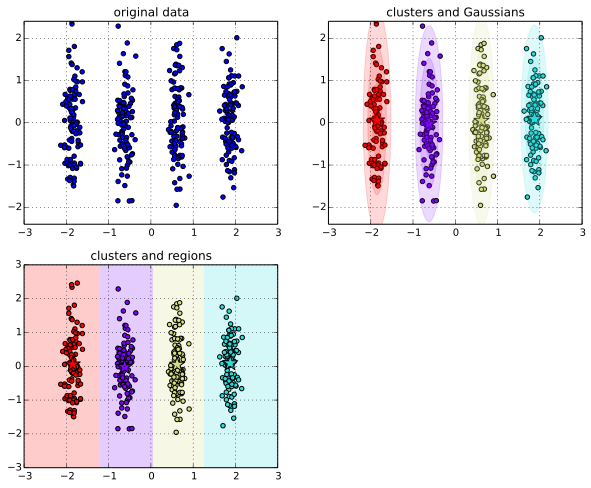

In [24]:
efig

# Covariance matrix
- The covariance matrix is a $d \times d$ matrix.
- For high-dimensional data, it can be very large.
  - requires a lot of data to learn effectively.
- **Solution:**
  - use diagonal covariance matrices ($d$ parameters)
    - Axes of ellipses will be aligned with the axes.
  - use spherical covariance matrices (1 parameter)
    - Clusters will be circular (similar to K-means)

In [25]:
random.seed(38)
mu1 = array([0,0])
mu2 = array([6,8])
st1 = 2*random.normal(0,1,(2,2))
st2 = 2*random.normal(0,1,(2,2))
X1 = dot(random.normal(0,1,[60, 2]), st1.T) + mu1
X2 = dot(random.normal(0,1,[60, 2]), st2.T) + mu2
Xfull = r_[X1,X2]

X = Xfull

In [26]:
gmmf = mixture.GMM(n_components=2, covariance_type='full', random_state=4487, n_init=10)
gmmf.fit(X)

gmmd = mixture.GMM(n_components=2, covariance_type='diag', random_state=4487, n_init=10)
gmmd.fit(X)

gmms = mixture.GMM(n_components=2, covariance_type='spherical', random_state=4487, n_init=10)
gmms.fit(X)

GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=10, n_iter=100, params='wmc', random_state=4487,
  thresh=None, tol=0.001)

In [27]:
efig = plt.figure(figsize=(10,6))

for i,gmm in enumerate([gmmf, gmmd, gmms]):
    ax = plt.subplot(2,3,i+1)
    plot_clusters(gmm, X, rbow)
    plt.axis('equal'); plt.grid(True)
    plt.title(gmm.covariance_type)

    # grid of points
    axbox = plt.axis()    
    plt.subplot(2,3,i+1+3)
    plt.axis(axbox); plt.grid(True)
    plot_clusters(gmm, X, rbow, showregions=True)
    
plt.close()

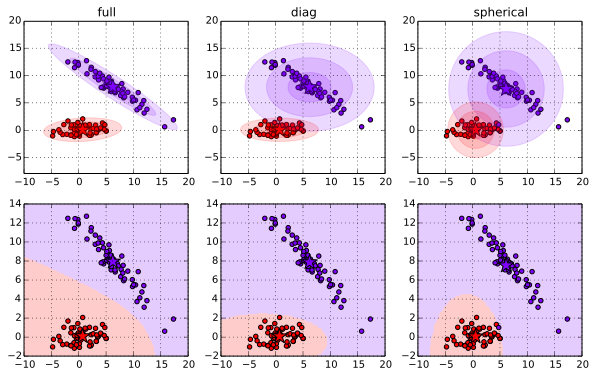

In [28]:
efig

# How to select K?
- Clustering results depends on the number of clusters used.
- We don't typically know this information beforehand.

# Dirichlet Process GMM
  - GMM is extended to automatically select the value of $K$
  - _concentration_ parameter $\alpha$ controls the range of $K$ values that are preferred
    - higher values encourage more clusters
    - lower values encourage less clusters
    - expected number of clusers is $\alpha \log N$, where $N$ is the number of points.

In [30]:
random.seed(123)

# alpha = concentration parameter
# n_components = the max number of components to consider
dpgmm = mixture.DPGMM(covariance_type='full', alpha=1, n_components=5, n_iter=100)
dpgmm.fit(X)

Y  = dpgmm.predict(X)  # predict cluster assignments
cl = unique(Y)         # find active clusters
cc = dpgmm.means_[cl]  # get means

In [31]:
dfig = plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.scatter(X[:,0],X[:,1], c='b')
plt.axis('equal'); plt.grid(True)

ax = plt.subplot(1,3,2)
Knew = plot_clusters(dpgmm, X, rbow)
plt.axis('equal'); plt.grid(True)
plt.title('DPGMM (' + str(dpgmm.n_components) + " -> " + str(Knew[0]) + " clusters)")

gmm = mixture.GMM(n_components=5, covariance_type='full', random_state=4487, n_init=10)
gmm.fit(X)

plt.subplot(1,3,3)
plot_clusters(gmm, X, rbow)
plt.axis('equal'); plt.grid(True)
plt.title('GMM (' + str(gmm.n_components) + " clusters)")
plt.close()

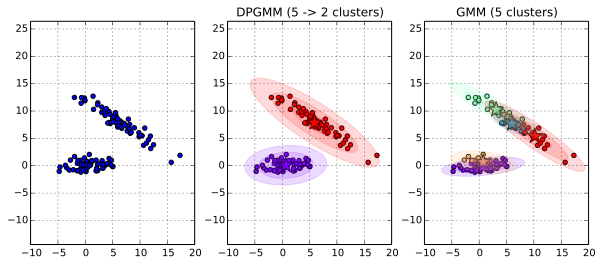

In [32]:
dfig

In [33]:
# make some random data
Xblob = array([])
random.seed(120)
for i in range(5):
    mu = random.uniform(-5,5,(1,2))
    
    st = 0.2*random.normal(0,1,(2,2)) + 0.2*identity(2)
    X1 = dot(random.normal(0,1,[60, 2]), st.T) + mu

    if i==0:
        Xblob = X1
    else:
        Xblob = r_[Xblob,X1]
X = Xblob

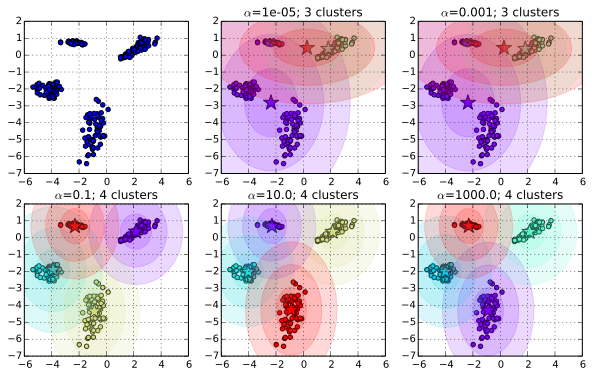

In [34]:
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
plt.scatter(X[:,0], X[:,1], c='b')
plt.grid(True)

for i,alpha in enumerate(logspace(-5,3,5)):
    dpgmm = mixture.DPGMM(covariance_type='diag', alpha=alpha, n_components=10, n_iter=10)
    dpgmm.fit(X)

    plt.subplot(2,3,i+2)
    Knew = plot_clusters(dpgmm, X, rbow)
    plt.grid(True)
    plt.title("$\\alpha$="+str(alpha)+"; " + str(Knew[0])+ " clusters")

# Mean-shift algorithm
- Clustering algorithm that also automatically selects the number of clusters.
- **Idea:** iteratively shift towards the largest concentration of points.
  - start from an initial point $x$ (e.g., one of the data points).
  - repeat until $x$ is unchanged:
    - 1) find the nearest neighbors to $x$ within some radius (bandwidth)
    - 2) set $x$ to be the mean of the neighbor points.

In [35]:
X = Xfull
x0 = X[3,:]

efigs = []
for i in range(6):
    if i % 2 == 0:
        efigs.append(plt.figure(figsize=(10,4)))

    cc,cl = cluster.mean_shift(X, bandwidth=3, max_iter=0, seeds=[x0])

    plt.subplot(1,2,i%2+1)
    plt.scatter(X[:,0], X[:,1], c='b')
    plt.plot(x0[0],x0[1], 'ro')
    circ = plt.Circle(x0, radius=3, color='r', alpha=0.2)
    plt.gca().add_patch(circ)
    plt.plot(cc[0,0],cc[0,1], 'go')
    plt.arrow(x0[0], x0[1], cc[0,0]-x0[0], cc[0,1]-x0[1], 
              width=0.1, length_includes_head=True, head_width=0.4, color='r')
    plt.axis('equal'); plt.grid(True)
    plt.title('iteration ' + str(i))
    
    x0 = cc[0,:]
    
    if i%2 == 1:
        plt.close()

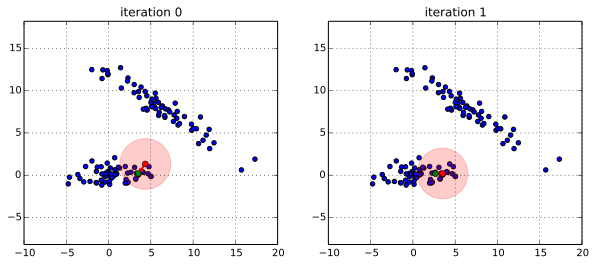

In [36]:
efigs[0]

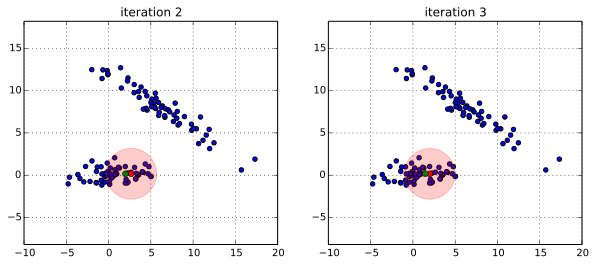

In [37]:
efigs[1]

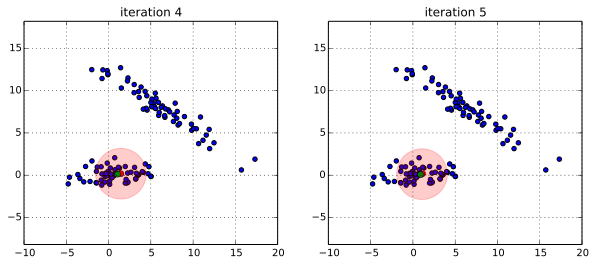

In [38]:
efigs[2]

# Getting the clusters
- Run the mean-shift algorithm for many initial points $\{x_i\}$.
  - the set of converged points contain the cluster centers.
    - need to remove the duplicate centers.
  - data points that converge to the same center belong to the same cluster.

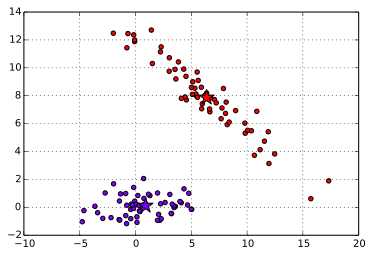

In [39]:
# bin_seeding=True -- coarsely uses data points as initial points
ms = cluster.MeanShift(bandwidth=5, bin_seeding=True)
ms.fit(X)

cc = ms.cluster_centers_  # cluster centers
cl = ms.labels_           # labels

plot_clusters(ms, X, rbow)
plt.grid(True)

# Number of clusters
- Number of clusters is implicitly controlled by the bandwidth (radius of the nearest-neighbors)

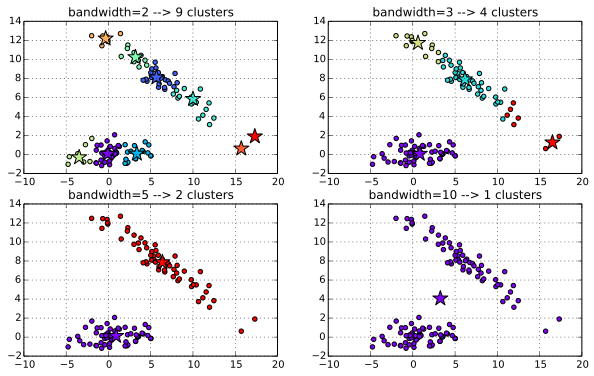

In [40]:
plt.figure(figsize=(10,6))
for i,bw in enumerate([2, 3, 5, 10]):
    ms = cluster.MeanShift(bandwidth=bw, bin_seeding=True)
    ms.fit(X)

    plt.subplot(2,2,i+1)
    plot_clusters(ms, X, rbow)
    plt.grid(True)
    plt.title('bandwidth=%d --> %d clusters' % (bw,len(ms.cluster_centers_)))

# Non-compact clusters
- K-means, GMM, and Mean-Shift assume that all clusters are compact.
  - i.e., circles or ellipses
- What about clusters of other shapes?
  - e.g., clusters not defined by compact distance to a "center"

In [41]:
random.seed(200)
X1 = 0.2*random.normal(0,1,[50, 2])
X1[:,1] *= 8
X1[:,0] += 0.3*power(X1[:,1],2) - 5

X2 = 0.4*random.normal(0,1,[50,2])-array([2,0])
X3 = 0.4*random.normal(0,1,[50,2])+array([2,0])

X4 = 0.2*random.normal(0,1,[50, 2])
X4[:,1] *= 8
X4[:,0] -= 0.3*power(X4[:,1], 2) - 5

Xtie = r_[X1,X2,X3,X4]

X = Xtie

km = cluster.KMeans(n_clusters=4, random_state=1234)
km.fit(X)

gmmf = mixture.GMM(n_components=4, covariance_type='full', random_state=4487, n_init=10)
gmmf.fit(X)

ms = cluster.MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(X)

tiefig = plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c='b')
plt.grid(True)
plt.title('data')

for i,m in enumerate([km, gmmf, ms]):
    plt.subplot(2,2,i+2)
    plot_clusters(m, X, rbow)
    plt.grid(True)
    plt.title(m.__class__.__name__)
plt.close()

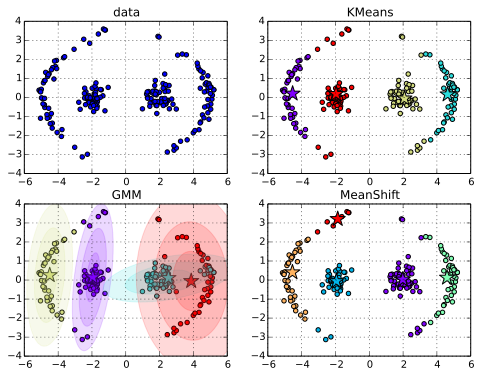

In [42]:
tiefig

In [45]:
Xcirc,Y = datasets.make_circles(n_samples=300, noise=0.05, factor=0.2)
X = Xcirc

km = cluster.KMeans(n_clusters=2, random_state=1234)
km.fit(X)

gmmf = mixture.GMM(n_components=2, covariance_type='full', random_state=4487, n_init=10)
gmmf.fit(X)

ms = cluster.MeanShift(bandwidth=0.5, bin_seeding=True)
ms.fit(X)

circfig = plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c='b')
plt.grid(True)
plt.title('data')

for i,m in enumerate([km, gmmf, ms]):
    plt.subplot(2,2,i+2)
    plot_clusters(m, X, rbow)
    plt.grid(True)
    plt.title(m.__class__.__name__)
plt.close()

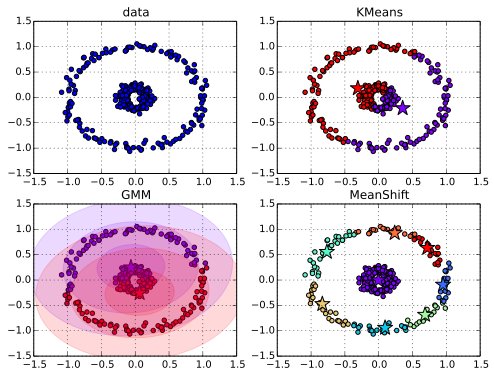

In [46]:
circfig

# Spectral Clustering
- Estimate the clusters using the pair-wise affinity between points.
- Affinity (similarity) between points 
  - kernel function: $k(x_i,x_j)$ -- RBF kernel
  - number of nearest neighbors within a radius (bandwidth)

In [47]:
X = Xtie
sc = cluster.SpectralClustering(n_clusters=4, affinity='rbf', gamma=1.0, assign_labels='discretize')
Y = sc.fit_predict(X)  # cluster and also return the labels Y

cl = sc.labels_  # labels for each X
ii = random.permutation(len(cl))

afig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c='b')
plt.title('Data'); plt.grid(True)

plt.subplot(1,2,2)
plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest')
plt.title('affinity matrix')
plt.close()

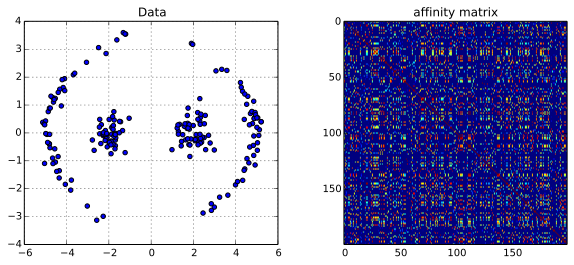

In [48]:
afig

# Spectral Clustering
- **Idea:** clustering with a graph formulation
  - each data point is a node in a graph
  - edge weight between two nodes is the affinity $k(x_i,x_j)$
- **Goal:** cut the graph into clusters such that weights of cut edges is small compared to the total edge weight within each cluster.
  - find "blocks" of high affinity in the affinity matrix.

In [49]:
X = Xtie

# spectral clustering
# rbf affinity
sc = cluster.SpectralClustering(n_clusters=4, affinity='rbf', gamma=1.0, assign_labels='discretize')
sc.fit_predict(X)

cl = sc.labels_  # labels for each X

In [51]:
ii = argsort(sc.labels_)
scfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest')
plt.title('sorted affinity matrix')

plt.subplot(1,2,2)
plot_clusters(sc, X, rbow)
plt.grid(True)
plt.close()

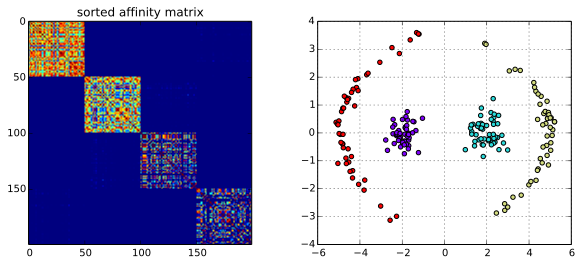

In [52]:
scfig

In [54]:
X = Xcirc

sc = cluster.SpectralClustering(n_clusters=2, affinity='rbf', gamma=10, assign_labels='discretize')
sc.fit_predict(X)

ii = argsort(sc.labels_)

scfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest')
plt.title('sorted affinity matrix')

plt.subplot(1,2,2)
plot_clusters(sc, X, rbow)
plt.grid(True)
plt.close()

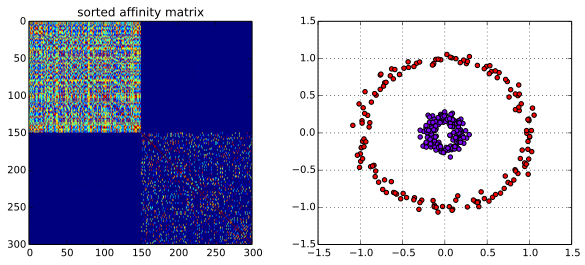

In [55]:
scfig

# Clustering Summary
- **Goal:** given set of input vectors $\{x_i\}_{i=1}^n$, with $x_i\in\mathbb{R}^d$, group similar $x_i$ together into clusters.
  - estimate a cluster center, which represents the data points in that cluster.
  - predict the cluster for a new data point.
  
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Cluster Shape</th>
<th>Principle</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>K-Means</td>
<td>circular</td>
<td>minimize distance to cluster center</td>
<td>- scalable (MiniBatchKMeans)</td>
<td>- sensitive to initialization; could get bad solutions due to local minima.<br>- need to choose K.</td>
</tr>
<tr>
<td>Gaussian Mixture Model</td>
<td>elliptical</td>
<td>maximum likelihood</td>
<td>- elliptical cluster shapes.</td>
<td>- sensitive to initialization; could get bad solutions due to local minima.<br>- need to choose K.</td>
</tr>
<tr>
<td>Dirichlet Process GMM</td>
<td>elliptical</td>
<td>maximum likelihood</td>
<td>- automatically selects K via concentration parameter.</td>
<td>- can be slow.<br>- sensitive to initialization; could get bad solutions due to local minima.</td>
</tr>
<tr>
<td>Mean-Shift</td>
<td>concentrated compact</td>
<td>move towards local mean</td>
<td>- automatically selects K via bandwidth parameter.</td>
<td>- can be slow.</td>
</tr>
<tr>
<td>Spectral clustering</td>
<td>irregular shapes</td>
<td>graph-based</td>
<td>- can handle clusters of any shape, as long as connected.</td>
<td>- need to choose K.<br>- cannot assign novel points to a cluster.</td>
</tr>
</table>

# Other Things
- _Feature normalization_
  - feature normalization is typically required clustering.
  - e.g., algorithms based on Euclidean distance (Kmeans, Mean-Shift, Spectral Clustering)